In [1]:
%reload_ext autoreload
%autoreload 2
from utils.bigram import *
from utils.helpers import *

# load val_data by crawling the list of wiki pages in "dataset/val_wiki.json"
val_data, val_urls = load_val_data(num_pages=10)
train_data, num_chars = crawl_wiki_data(new_links, visited_urls, num_chars, add=1e5, printer=True)

# instantiate model
model = BigramLanguageModel(vocab_size)
model = nn.DataParallel(model)
model = model.to(device) # move model parameters to gpu if available

CUDA_VISIBLE_DEVICES = 0,1,2,3,4,5,6,7
device: cuda
num_chars_init:0  len(new_links):1, len(visited_urls):10                                                                                                    

page_length:128.3K, len(new_links):1605, len(visited_urls):11, num_chars:128.32K  https://www.wikipedia.org/wiki/David_Bowie                                                                      
Exiting crawl_wiki_data(): len(new_links): 1605  len(visited_urls):11   (...Runtime: 0 min  6 sec)                                                                                                    
num_params: 34M


In [2]:
# Create a pytorch optimizer
optimizer = torch.optim.AdamW(model.parameters(), lr=learning_rate)  # usually 3e-4 for bigger networks.

list_epochs, list_losses, list_epochs_eval, list_losses_eval = [0], [], [0], [] 

xb, yb, pivot = get_batch_sequentially(train_data, batch_size, pivot=0)

logits, loss = model(xb, yb)
if device.startswith('cuda') and torch.cuda.device_count() > 1:
    loss = np.mean(loss.tolist())
list_losses.append(loss.tolist())
losses = estimate_loss(model, train_data, val_data, eval_iters, -1, time.time())


list_losses_eval.append([item.detach().numpy().tolist() for item in (losses['train'], losses['val'])])

print(f'logits.shape (block_size * batch_size: {logits.shape}')
print(f'loss: {loss:.3f}')
print(r''.join(decode(generate(model, torch.zeros((1,1), device=device, dtype=torch.long) * 35,
                               max_new_tokens=100)[0].tolist())))

/data/home/osafak/.conda/envs/pt_env/lib/python3.8/site-packages/torch/nn/parallel/_functions.py:64: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '


step -1:   train_loss:4.8441, val_loss:4.8384  (...Runtime: 0 min 53 sec)
logits.shape (block_size * batch_size: torch.Size([16384, 97])
loss: 4.844
	<$u[A^?AO`vT`U?s&Qiw<`Z1P2pQqqF.CAKDOpwmYXgrh-m5N(+2cRgLzhi*CrN1Mr]hs/("rLY`r)dc~_dsP@#dSd0N{@L8brD?


In [ ]:
# train loop
start = time.time()
epoch = 0

for ib in range(1, max_iters + 1):
    # sample a batch of data
    xb, yb, pivot = get_batch_sequentially(train_data, batch_size, pivot)
    
    if xb is None:
        train_data, num_chars = crawl_wiki_data(new_links, visited_urls, num_chars, add=1e5, printer=True)
        xb, yb, pivot = get_batch_sequentially(train_data, batch_size, pivot)
        
    
    # evaluate the loss
    logits, loss = model(xb, yb)
    if device.startswith('cuda'):
        loss = loss.mean()
    optimizer.zero_grad(set_to_none=True)
    loss.backward() # get the gradients
    optimizer.step() # update parameters using the gradients
    
    # evaluate at fixed intervals
    epoch += 1e6 / (block_size * batch_size)
    if ib % eval_interval == 0 or ib == max_iters - 1:
        losses = estimate_loss(model, train_data, val_data, eval_iters, ib, start)
        list_epochs_eval.append(epoch)
        list_losses_eval.append([item.detach().numpy().tolist() for item in (losses['train'], losses['val'])])
    list_losses.append(loss.item())
    list_epochs.append(epoch)

plotter(list_epochs, list_losses, list_epochs_eval, list_losses_eval)

# Generate text 
context = torch.zeros((1,1), dtype=torch.long, device=device)
print(r''.join(decode(generate(model, torch.zeros((1,1), device=device, dtype=torch.long) * 35, 
                               max_new_tokens=400)[0].tolist()))) 

 ==> Not enough tokens in data. Need (batch_size * block_size) tokens in data, but len(data) = 128319, max_batches = 501
num_chars_init:128319  len(new_links):1605, len(visited_urls):11                                                                                                    

page_length:  2.2K, len(new_links):1622, len(visited_urls):12, num_chars:130.48K  https://www.wikipedia.org/wiki/Paul_Trynka                                                                      
page_length:109.2K, len(new_links):2804, len(visited_urls):13, num_chars:239.67K  https://www.wikipedia.org/wiki/Igor_Stravinsky                                                                      
Exiting crawl_wiki_data(): len(new_links): 2804  len(visited_urls):13   (...Runtime: 0 min  1 sec)                                                                                                    
 ==> Not enough tokens in data. Need (batch_size * block_size) tokens in data, but len(data) = 111350, max_batches = 434

page_length:103.1K, len(new_links):10731, len(visited_urls):36, num_chars:1.09M  https://www.wikipedia.org/wiki/Morocco                                                                      
Exiting crawl_wiki_data(): len(new_links): 10731  len(visited_urls):36   (...Runtime: 0 min  1 sec)                                                                                                    
 ==> Not enough tokens in data. Need (batch_size * block_size) tokens in data, but len(data) = 103071, max_batches = 402
num_chars_init:1087427  len(new_links):10731, len(visited_urls):36                                                                                                    

page_length: 43.0K, len(new_links):10976, len(visited_urls):37, num_chars:1.13M  https://www.wikipedia.org/wiki/Belgian_local_elections,_2018                                                                      
page_length:  8.3K, len(new_links):11021, len(visited_urls):38, num_chars:1.14M  https://www.wikipedia.org/wi

# The Mathematical Trick in Self-Attention

- Attention is a **communication mechanism**. It's anodes in a graph looking at each other and aggregating informtaion with a weighted sum from all nodes pointing to them  

- No notion of space. Attention itself only acts over nodes and vectors.

- Separate batches don't talk to each other. Each example across batch dimension is processed independently. 

- **Encoder:**  No masking with `tril` allowing all tokens to communicate. **Decoder** uses masking in an autoregressive settings so past tokens don't talk to future tokens --otherwise they would give away the answer.

- **Self-Attention:** keys, queries and values arecome from the same source. 
- **Cross-Attention:** queries are produced from x, keys and values are produced from a previous encoder module. Encoder encodes some context we want the decoder's generation process to be conditioned on.
- **Scaling by sqrt(d):** It's an important normalization to have. 


----
## 1. Experiments

## 2. Experiments
---

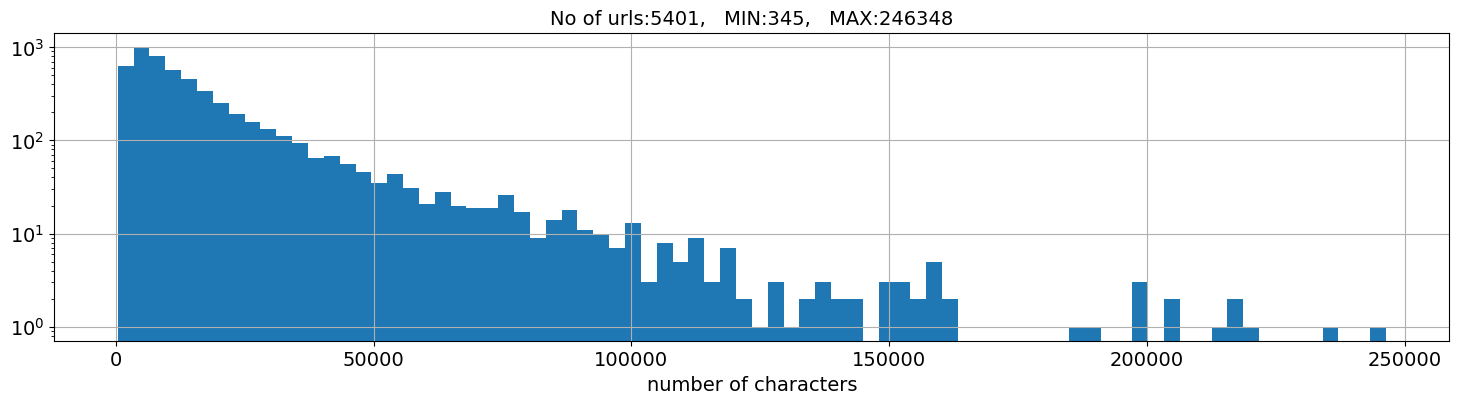

In [2]:
dirname='dataset/repo_wiki/'
fnames = sorted(glob.glob(f'{dirname}/*pkl'))
wikis = dict()
for fname in fnames:
    with open(fname, 'rb') as f:
        wikis.update(pickle.load(f)) 

urls = list(wikis.keys())
out = [(len(wikis[url])) for url in (urls)]
x, y, patches  = plt.hist(out, bins=80, log=True); plt.xlabel('number of characters'); 
plt.title(f'No of urls:{len(urls)},   MIN:{min(out)},   MAX:{max(out)}');


/data/home/osafak/.conda/envs/pt_env/lib/python3.8/site-packages/IPython/core/events.py:89: UserWarning: Glyph 9 (	) missing from current font.
  func(*args, **kwargs)
/data/home/osafak/.conda/envs/pt_env/lib/python3.8/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 9 (	) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


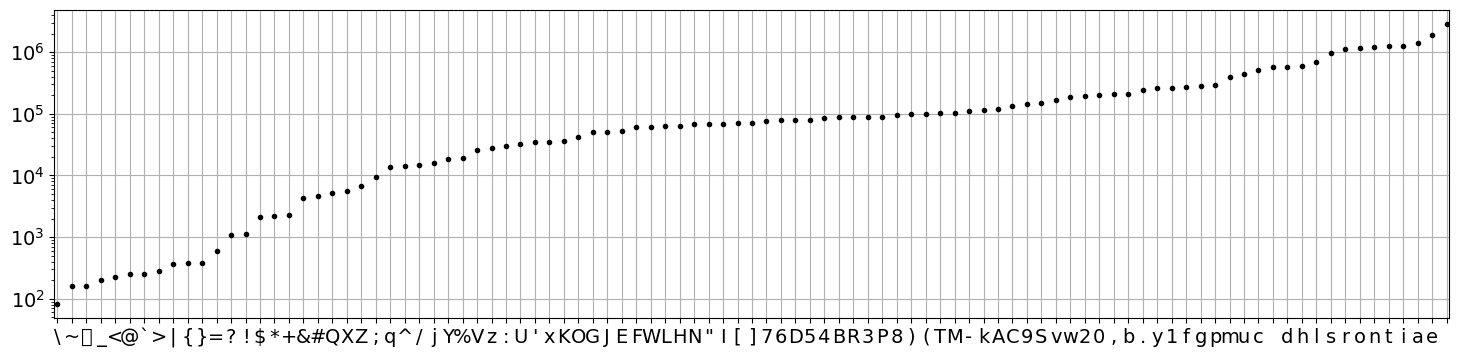

In [3]:
cnt = plot_character_frequency(urls[:1000], wikis)